In [2]:
from IPython.core.display import HTML
HTML("""
<style>
code {
    padding:2px 4px !important;
    color: #c7254e !important;
    font-size: 90%;
    background-color: #f9f2f4 !important;
    border-radius: 4px !important;
    color: rgb(138, 109, 59);
    font-weight: bold;
}
mark {
    color: rgb(138, 109, 59) !important;
    font-weight: bold !important;
}
.container { width: 90% !important; }
table { font-size:15px !important; }
</style>
""")

In [3]:
import sys, math, os
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt    
import numpy as np

sys.path.insert(0, '../../src/data/')
import utils

%matplotlib inline
%load_ext autoreload  
%autoreload 2  

path_raw = "../../data/raw/beer_reviews"

Quick way of getting the notebook name, see [here](https://stackoverflow.com/a/23619544/1153897) for source; notebook name will be in python variable `notebook`.

In [4]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "notebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

# Introduction

This notebook serves as an intial exploratory look into the beer review data provided for the CiBO data science exercise. In order to generate the data, please run `make data` from the project root directory.

## Initial thoughts

General questions to think about:
- is each beer equally represented in the reviews, or do some beers get more/less reviews?
- do we have all the data, or are there datum missing? If so, we may have to impute
- are there any gross outliers which we should be careful of?
- if every beer was equally reviewed, how many reviews would we expect each beer to have?
- is each brewery equally represented in reviews?
- does each brewery have the same count of number of beers reviewed?
- do any of the reviewers have an "outlier" taste profile or do they rank beers quite differently to others?
- are the beer_style equally represented?

In [5]:
# LOAD DATA
# we assume the file we're after is a
# single .csv in path_raw
for file in os.listdir(path_raw):
    file = os.path.join(path_raw, file)
    if os.path.isfile(file) and '.csv' in file: 
        dat_raw = pd.read_csv(file)
    

# DF of beer metadata
beer_meta_cols = ['brewery_id', 'brewery_name','beer_style', 'beer_name','beer_abv']
beer_dat = dat_raw.groupby('beer_beerid').agg('first')[beer_meta_cols]

dat_raw.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


In [6]:
dat_raw.dtypes

brewery_id              int64
brewery_name           object
review_time             int64
review_overall        float64
review_aroma          float64
review_appearance     float64
review_profilename     object
beer_style             object
review_palate         float64
review_taste          float64
beer_name              object
beer_abv              float64
beer_beerid             int64
dtype: object

In [7]:
# check if any of the string type columns contain special accents
ascii = dat_raw.select_dtypes(include=[object]).applymap(utils.is_not_ascii)
ascii.sum() > 0

brewery_name           True
review_profilename    False
beer_style             True
beer_name              True
dtype: bool

The beer review data is organized in a *tall* fashion; that is, each beer will have multiple row entries, each row pertaining to a review for that beer. The following attribute fields have special characters in them: `brewery_name`, `beer_style`, `beer_name`.
<hr>

## Missing data

In [8]:
# check for missing data
# replace blank values with NAN,
# then count the NANs
nans = dat_raw.replace('', np.nan).isnull().sum()
nans[nans > 0]

/Library/Python/2.7/site-packages/pandas/core/common.py:449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x


brewery_name             15
review_profilename      348
beer_abv              67785
dtype: int64

Several attributes have missing values: `brewery_name`, `review_profilename` and `beer_abv`. We aren't too concerned about `brewery_name` since we have associated `brewery_id` with them. However, `review_profilename` will be needed if we want to compare across reviewers. The missing values for `beer_abv` are also concerning since we are after the beer with highest ABV% -> we might want to build a model to predict ABV and use that to impute missing values for `beer_abv`

In [9]:
empty_abv_beer = beer_dat[beer_dat.beer_abv.isnull()]

print 'Number of beers without an ABV%%: %s' %empty_abv_beer.shape[0]

Number of beers without an ABV%: 17043


<hr>

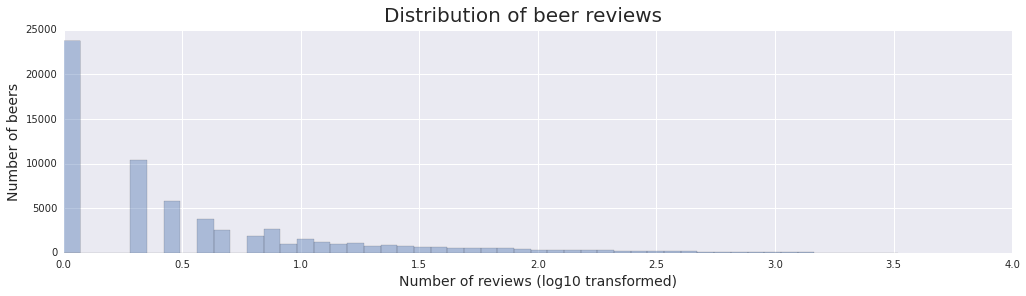

In [46]:
counts = dat_raw.groupby('beer_beerid').count()
utils.draw_hist(counts.brewery_id.tolist(), 
                'Number of reviews', 
                'Number of beers', 
                'Distribution of beer reviews', 
                log=True)

plt.savefig('../reports/figures/1.0_initial_look-0.svg')

In [11]:
counts[['brewery_id']].describe()

,brewery_id
count,66055.000000
mean,24.019590
std,110.864191
min,1.000000
25%,1.000000
50%,2.000000
75%,7.000000
max,3290.000000


We see there are a total of 66,055 beers with a wide range of number of reviews. 

The median number of reviews is 2, whereas the mean number of reviews is ~24 -> <mark>there's a clear skew for beers only reviewed a few times.</mark>

<hr>

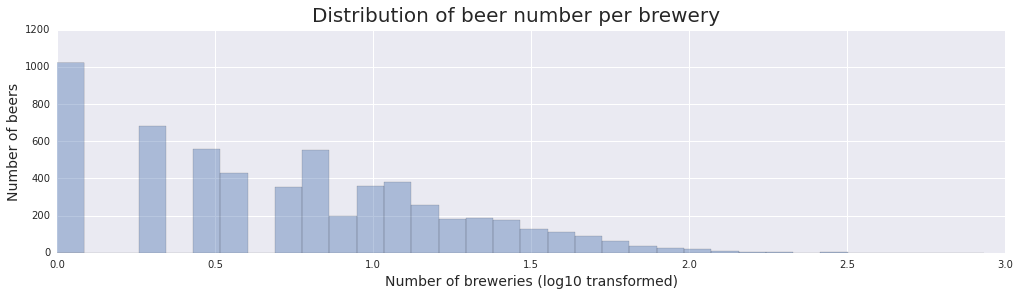

In [47]:
beer_count = beer_dat.groupby('brewery_id').count()
utils.draw_hist(beer_count.beer_name.tolist(), 
                'Number of breweries', 
                'Number of beers', 
                'Distribution of beer number per brewery', 
                log=True)

plt.savefig('../reports/figures/1.0_initial_look-1.svg')

In [13]:
beer_count[['beer_name']].describe() # careful not to use counts on 'brewery_id' since it has missing values!

,beer_name
count,5840.000000
mean,11.310788
std,22.177115
min,1.000000
25%,2.000000
50%,5.000000
75%,12.000000
max,855.000000


There are a total of 5840 breweries which get an average of ~11 beers reviewed. The median number of beers reviewed per brewery is 5, whereas the max is 855 and the min is 1.

<hr>

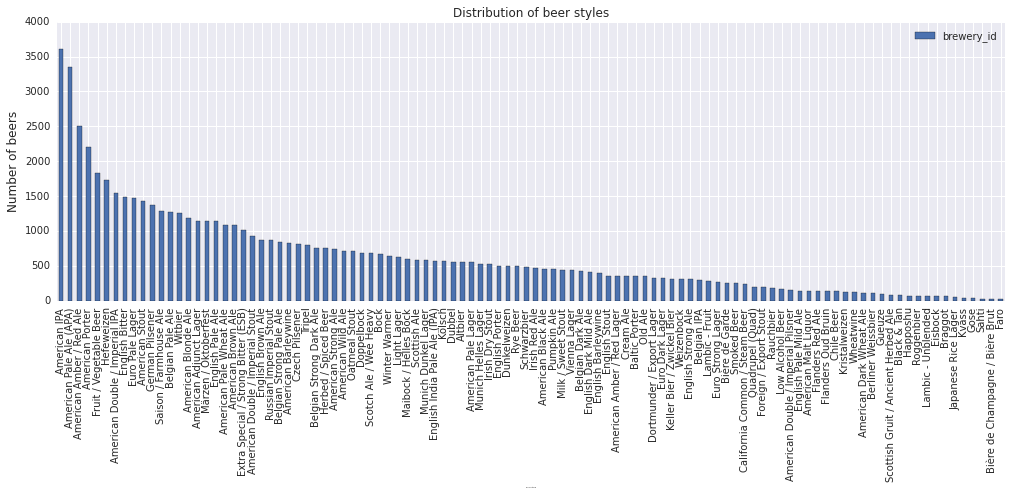

In [68]:
beer_style_counts = beer_dat.groupby('beer_style').count().sort_values('brewery_id', ascending=False)
ax = beer_style_counts[['brewery_id']].plot(kind='bar', 
                                            figsize=(17,5), 
                                            title='Distribution of beer styles')

ax.set_ylabel("Number of beers", fontsize=12)
ax.set_xlabel("Beer style", fontsize=2)
plt.show()

fig = ax.get_figure()
fig.tight_layout()
fig.savefig('../reports/figures/1.0_initial_look-2.svg')

In [15]:
beer_style_counts[['brewery_id']].describe()

,brewery_id
count,104.000000
mean,635.144231
std,635.949125
min,19.000000
25%,196.750000
50%,476.000000
75%,816.250000
max,3611.000000


<hr>

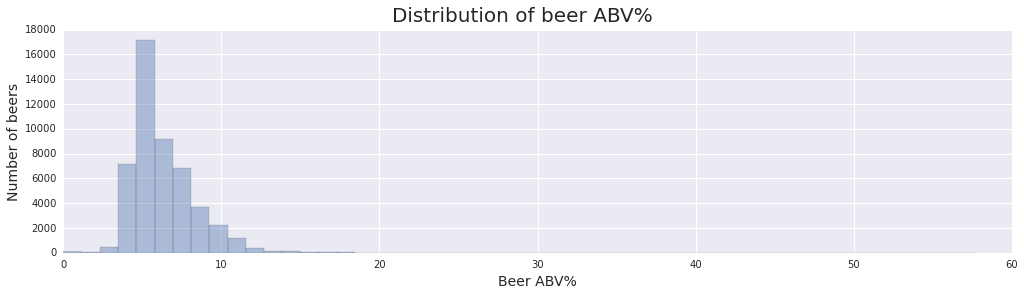

In [49]:
abv = beer_dat[beer_dat.beer_abv.notnull()].sort_values('beer_abv', ascending=False)
utils.draw_hist(abv.beer_abv.tolist(), 
                'Beer ABV%', 
                'Number of beers', 
                'Distribution of beer ABV%')

plt.savefig('../reports/figures/1.0_initial_look-3.svg')

In [17]:
abv[['beer_abv']].describe()

,beer_abv
count,49012.000000
mean,6.271890
std,2.050938
min,0.010000
25%,5.000000
50%,5.700000
75%,7.200000
max,57.700000


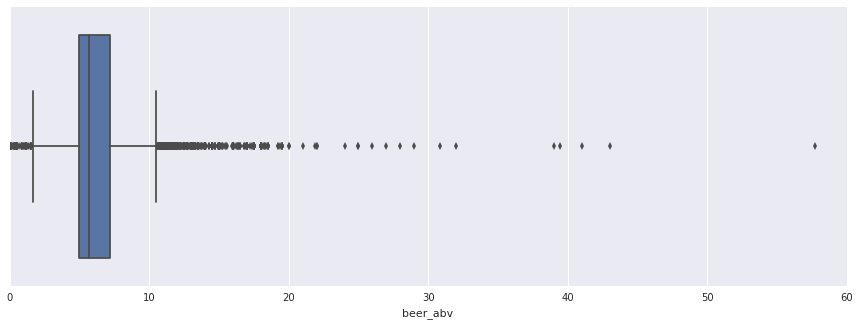

In [50]:
plt.figure(figsize=(15,5))
ax = sns.boxplot(abv.beer_abv)
plt.savefig('../reports/figures/1.0_initial_look-4.svg')

For those beers that have an ABV% value, the total distrubtion looks roughly normal (with a long right tail); there are quite a few number of outliers to take care of.

<hr>

Check the overall distributions of beer scores

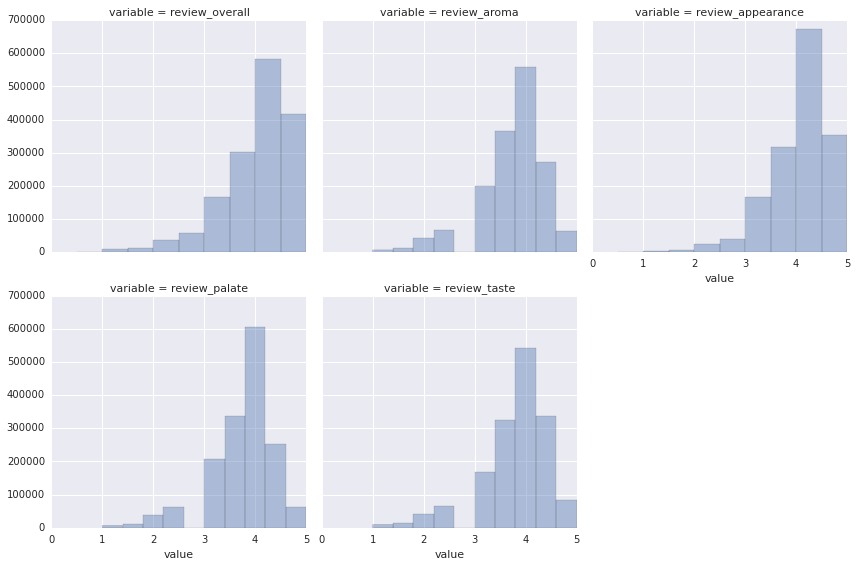

In [51]:
melt = pd.melt(dat_raw, id_vars = ['beer_beerid'], value_vars=['review_overall', 
                                                               'review_aroma',
                                                               'review_appearance',
                                                               'review_palate',
                                                               'review_taste'])

g = sns.FacetGrid(melt, col="variable", col_wrap=3, size=4)
g.map(sns.distplot, 'value', kde=False, bins=10)
plt.savefig('../reports/figures/1.0_initial_look-5.svg')